# Etapa 1 | Carregamento, Pré-Processamento Inicial e Divisão dos Dados

In [1]:
# ETAPA 1.0 | Bibliotecas necessárias

import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from typing import List, Dict, Any, Union
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PowerTransformer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ETAPA 1.1 | Carregar dados do Kaggle

def carregarDados(caminhoData: str) -> pd.DataFrame | None:
    """
    Carrega e unifica os arquivos CSV do Kaggle dataset
    ('time_domain', 'heart_rate_non_linear', 'frequency_domain').
    """

    dataframes = {}

    try:
        csvFiles = [f for f in os.listdir(caminhoData) if f.endswith('.csv')]

        if not csvFiles:
            print("ERRO: Nenhum arquivo CSV encontrado.")
            return None

        for fileName in csvFiles:
            fullPath = os.path.join(caminhoData, fileName)
            dfTemp = pd.read_csv(fullPath)

            keyName = fileName.split('.csv')[0]
            dataframes[keyName] = dfTemp
            print(f"✅ Carregado: {keyName} - {dfTemp.shape}")

    except Exception as e:
        print(f"Erro ao carregar: {e}")
        return None

    # Tentando identificar automaticamente quais são time / nonlinear / freq
    possiveisChaves = list(dataframes.keys())

    def buscarChave(texto):
        for key in possiveisChaves:
            if texto in key.lower():
                return key
        return None

    chaveTime = buscarChave('time')
    chaveNonLinear = buscarChave('non')
    chaveFreq = buscarChave('frequency')

    if not all([chaveTime, chaveNonLinear, chaveFreq]):
        print("ERRO: Arquivos esperados não encontrados corretamente.")
        print("Arquivos encontrados:", possiveisChaves)
        return None

    dfMerged = pd.merge(
        dataframes[chaveTime],
        dataframes[chaveNonLinear],
        on='uuid',
        how='inner'
    )

    dfFinal = pd.merge(
        dfMerged,
        dataframes[chaveFreq],
        on='uuid',
        how='inner'
    )

    print(f"\n✅ Dataset unificado com sucesso: {dfFinal.shape}")

    return dfFinal


In [3]:
# ETAPA 1.2 | Transformação inicial dos dados

def transformarDados(df: pd.DataFrame, colunaAlvo: str = 'HR'):
    """
    Separa variáveis preditoras (X) e alvo (Y),
    remove colunas irrelevantes e aplica One-Hot Encoding em 'condition'.
    """

    if df is None:
        print("ERRO: DataFrame vazio.")
        return None, None

    # Colunas que não agregam valor (apenas identificadores)
    colunasParaRemover = ['uuid', 'datasetId']

    # Variável alvo (formato coluna para álgebra linear)
    Y = df[colunaAlvo].values.reshape(-1, 1)

    # Variáveis preditoras (remove alvo + ids)
    X = df.drop(columns=[colunaAlvo] + colunasParaRemover, errors='ignore').copy()

    # One-Hot Encoding para variável categórica 'condition'
    # drop_first=True evita multicolinearidade perfeita
    if 'condition' in X.columns:
        X = pd.get_dummies(X, columns=['condition'], drop_first=True)

    return X, Y

In [4]:
# ETAPA 1.3 | Separação em treino e teste

def dividirTreinoTeste(X, Y, tamanhoTeste=0.2, estadoAleatorio=27):
    """
    Divide os dados em conjunto de treinamento e teste.
    """

    # Separação usando proporção definida (ex: 80% treino / 20% teste)
    XTrain, XTest, YTrain, YTest = train_test_split(
        X, Y, test_size=tamanhoTeste, random_state=estadoAleatorio
    )

    print(f"\n✅ Divisão do Conjunto de Dados: CONCLUÍDA!")
    print(f"   Treino: {XTrain.shape}")
    print(f"   Teste: {XTest.shape}")

    return XTrain, XTest, YTrain, YTest

In [5]:
# ETAPA 1.4 | Pré-processamento dos preditores com Yeo-Johnson seletivo

def preProcessarFeatures(XTrainRaw, XTestRaw, skewnessThreshold=1.0):
    """
    Aplica transformação Yeo-Johnson APENAS às features numéricas com |skewness| > threshold
    e depois Padroniza todas as features numéricas (incluindo dummies),
    usando APENAS estatísticas do treino.
    """

    nomesFeatures = XTrainRaw.columns

    # 1. Separar features numéricas e categóricas
    featuresNumericas   = XTrainRaw.select_dtypes(include=[np.number]).columns.tolist()
    featuresCategoricas = XTrainRaw.select_dtypes(exclude=[np.number]).columns.tolist()

    print(f"\n✅ Features numéricas: {len(featuresNumericas)}")
    print(f"📝 Features categóricas (já codificadas): {len(featuresCategoricas)}")

    # 2. Calcular skewness apenas para features numéricas
    valoresSkewness = np.zeros(len(nomesFeatures))
    featuresParaTransformar = np.zeros(len(nomesFeatures), dtype=bool)

    if len(featuresNumericas) > 0:

        valoresSkew = stats.skew(
            XTrainRaw[featuresNumericas],
            axis=0,
            nan_policy='omit'
        )

        for i, feature in enumerate(nomesFeatures):
            if feature in featuresNumericas:
                indice = featuresNumericas.index(feature)
                valoresSkewness[i] = valoresSkew[indice]
                featuresParaTransformar[i] = abs(valoresSkew[indice]) > skewnessThreshold

        print(f"✅ {featuresParaTransformar.sum()} de {len(featuresNumericas)} features numéricas serão transformadas")
        print(f"   (Threshold de skewness: ±{skewnessThreshold})")

    # 3. Aplicar Yeo-Johnson nas features selecionadas
    XTrainTransf = XTrainRaw.copy()
    XTestTransf  = XTestRaw.copy()

    if featuresParaTransformar.any():

        colunasParaTransformar = nomesFeatures[featuresParaTransformar].tolist()

        transformadorPotencia = PowerTransformer(method='yeo-johnson')

        XTrainTransf[colunasParaTransformar] = transformadorPotencia.fit_transform(
            XTrainRaw[colunasParaTransformar]
        )

        XTestTransf[colunasParaTransformar] = transformadorPotencia.transform(
            XTestRaw[colunasParaTransformar]
        )

        print(f"\n✅ Transformação Yeo-Johnson aplicada em:\n{colunasParaTransformar}")

    else:
        transformadorPotencia = None
        print("\n⚠️ Nenhuma feature precisou de transformação Yeo-Johnson")


    # 4. PADRONIZAÇÃO (Z-SCORE)

    # Todas as features agora são numéricas (incluindo dummies)
    XMedia = XTrainTransf.mean(axis=0)
    XStd   = XTrainTransf.std(axis=0, ddof=1)

    # Evitar divisão por zero (features constantes)
    XStd[XStd == 0] = 1

    XTrainFinal = (XTrainTransf - XMedia) / XStd
    XTestFinal  = (XTestTransf  - XMedia) / XStd

    print("\n✅ Padronização (Z-score) concluída com estatísticas do conjunto de treino")

    return (
        XTrainFinal,
        XTestFinal,
        transformadorPotencia,
        featuresParaTransformar,
        valoresSkewness,
        XMedia,
        XStd
    )


In [6]:
# ETAPA 1.5 | Padronizar Saída

def padronizarAlvo(YTrain, YTest=None):
    """
    Padroniza Y usando estatísticas do conjunto de treino.
    Retorna YTrain_std, YTest_std (se YTest fornecido), media e desvio padrão.
    """

    # Garantir vetores coluna
    YTrainArr = np.asarray(YTrain).reshape(-1, 1)
    mediaY = np.mean(YTrainArr, axis=0)
    desvioY = np.std(YTrainArr, axis=0, ddof=1)

    # Evitar divisão por zero
    desvioY[desvioY == 0] = 1.0

    YTrainStd = (YTrainArr - mediaY) / desvioY

    if YTest is None:
        return YTrainStd, mediaY.item(), desvioY.item()
    else:
        YTestArr = np.asarray(YTest).reshape(-1, 1)
        YTestStd = (YTestArr - mediaY) / desvioY

        return YTrainStd, YTestStd, mediaY.item(), desvioY.item()


In [7]:
# EXECUÇÃO DA ETAPA 1 | Pipeline Completo

# 1.
path = kagglehub.dataset_download("vinayakshanawad/heart-rate-prediction-to-monitor-stress-level")
caminhoDados = os.path.join(path, 'Train Data', 'Train Data Zip')

df = carregarDados(caminhoDados)

# 2.
X, Y = transformarDados(df, colunaAlvo='HR')

# 3.
XTrainRaw, XTestRaw, YTrainOrig, YTestOrig = dividirTreinoTeste(
    X, Y,
    tamanhoTeste=0.2,
    estadoAleatorio=27
)

# 4.
XTrain, XTest, transformadorPotencia, featuresParaTransformar, valoresSkewness, XMedia, XStd = \
    preProcessarFeatures(XTrainRaw, XTestRaw, skewnessThreshold=1.0)

# 5.
YTrain, YTest, mediaY, desvioY = padronizarAlvo(YTrainOrig, YTestOrig)

Using Colab cache for faster access to the 'heart-rate-prediction-to-monitor-stress-level' dataset.
✅ Carregado: time_domain_features_train - (369289, 20)
✅ Carregado: frequency_domain_features_train - (369289, 12)
✅ Carregado: heart_rate_non_linear_features_train - (369289, 7)

✅ Dataset unificado com sucesso: (369289, 37)

✅ Divisão do Conjunto de Dados: CONCLUÍDA!
   Treino: (295431, 35)
   Teste: (73858, 35)

✅ Features numéricas: 33
📝 Features categóricas (já codificadas): 2
✅ 21 de 33 features numéricas serão transformadas
   (Threshold de skewness: ±1.0)

✅ Transformação Yeo-Johnson aplicada em:
['SDRR', 'SDRR_RMSSD', 'pNN25', 'pNN50', 'KURT', 'SKEW', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'SD2', 'sampen', 'VLF', 'LF', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF', 'HF_LF']

✅ Padronização (Z-score) concluída com estatísticas do conjunto de treino


In [8]:
# ETAPA EXTRA | Despadronizar X para o KFold
# XTrainTransf é X depois do Yeo-Johnson, mas ANTES do Z-Score (a inversão do Z-score global)!
XTrainTransf = XTrain * XStd + XMedia

# Etapa 2 | PLS

In [9]:
class PlsNipalsDoZero:
    """
    Implementação manual do PLS (NIPALS) para PLS1 (Y univariado).

    NOTA: X e Y DEVEM ser padronizados (média zero, desvio padrão unitário) antes
    de serem passados para o método 'treinar'!!!
    """

    def __init__(self, numeroComponentes=2):
        self.numeroComponentes = int(numeroComponentes)

        # Parâmetros internos do modelo (matrizes de carregamentos e scores)
        self.beta = None   # Coeficientes finais (p x 1) - para predição no espaço original
        self.W = None      # Pesos de X (Weightings) - define a direção das componentes
        self.P = None      # Carregamentos de X (Loadings) - como X é explicado por t
        self.T = None      # Scores (Componentes latentes) - o novo espaço de dados
        self.B = None      # Coeficientes de regressão de Y em T

    def treinar(self, X: pd.DataFrame | np.ndarray, Y: np.ndarray):

        # 1. Preparação dos Dados
        if isinstance(X, pd.DataFrame):
            Xarr = X.values.astype(np.float64)
        else:
            Xarr = X.astype(np.float64)

        # Y deve ser uma matriz (n x 1)
        Yarr = np.asarray(Y, dtype=np.float64).reshape(-1, 1)

        n, p = Xarr.shape

        # Inicialização das matrizes de armazenamento
        W = np.zeros((p, self.numeroComponentes))
        T = np.zeros((n, self.numeroComponentes))
        P = np.zeros((p, self.numeroComponentes))
        B = np.zeros((self.numeroComponentes, 1))

        # E e F são as matrizes de resíduos de X e Y (inicialmente, os dados padronizados)
        E = Xarr.copy()
        F = Yarr.copy()

        # 2. Loop de Extração de Componentes
        for h in range(self.numeroComponentes):

            # Passo 1 | Cálculo do Vetor de Pesos (w)
            # w é o vetor que maximiza a covariância entre E e F (resíduos de X e Y).
            # Para PLS1 (Y univariado), podemos calcular w DIRETAMENTE.
            w = E.T @ F         # Vetor de covariância (p x 1)

            # Normalizar w para que tenha norma (comprimento) 1
            normw = np.linalg.norm(w)
            if normw == 0:
                print(f"Aviso: Parando na componente {h+1} devido a vetor de pesos zero.")
                break
            w = w / normw       # w é agora um vetor de pesos unitário (p x 1)

            # Passo 2 | Cálculo do Score (t)
            # t é a nova componente latente (variável sintética) para X.
            # É a projeção dos dados E (resíduos de X) na direção definida por w.
            t = E @ w           # (n x 1)

            # Denominador comum (t^T t) - quadrado da norma de t
            denom_tt = float(t.T @ t)
            if denom_tt == 0:
                break

            # Passo 3 | Cálculo do Carregamento (p) para X
            # p descreve como as variáveis originais (colunas de X) se relacionam com a componente t.
            # É o coeficiente de regressão de E em t.
            p_vec = (E.T @ t) / denom_tt # (p x 1)

            # Passo 4 | Cálculo do Coeficiente de Regressão (c) para Y
            # c descreve a relação linear entre a nova componente t e a resposta residual F.
            c = (F.T @ t) / denom_tt # (1 x 1)

            # Passo 5 | Armazenamento
            W[:, h] = w.ravel()
            T[:, h] = t.ravel()
            P[:, h] = p_vec.ravel()
            B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F

            # Passo 6 | Deflação (Remoção da Informação Explicada)
            # Removemos a variação capturada pela componente t dos resíduos de X (E) e Y (F),
            # para que a próxima componente (h+1) capture apenas a variação restante.
            E = E - np.outer(t.ravel(), p_vec.ravel()) # Deflação de X: E = E - t p^T
            F = F - c * t                             # Deflação de Y: F = F - c t

        # 3. Cálculo dos Coeficientes Finais (Beta)
        # O modelo PLS é uma regressão de T em Y (B). Precisamos dos coeficientes no espaço original (Beta).
        # A relação é dada por: Beta = W * (P^T W)^-1 * B

        # A matriz (P^T W) é a matriz de inter-relações entre os carregamentos e os pesos.
        PTW = P.T @ W # (r x r), onde r é o número de componentes

        # Resolver o sistema linear: (P^T W) * gamma = B, então gamma = (P^T W)^-1 * B
        try:
            # np.linalg.solve é mais rápido e preciso para sistemas não singulares
            gamma = np.linalg.solve(PTW, B) # (r x 1)
        except np.linalg.LinAlgError:
            # Se a matriz for singular (raro mas possível), usamos a pseudo-inversa (proteção numérica)
            gamma = np.linalg.pinv(PTW) @ B

        # O vetor Beta final (p x 1) transforma X diretamente em Y predito
        beta = W @ gamma # (p x 1)

        # Salvar os resultados do treinamento
        self.beta = beta
        self.W = W[:, :h+1] # Armazena apenas as componentes válidas
        self.P = P[:, :h+1]
        self.T = T[:, :h+1]
        self.B = B[:h+1, :]

        return self

    def predizer(self, X: pd.DataFrame | np.ndarray) -> np.ndarray:
        """
        Calcula as predições no conjunto de dados X.
        Nota: X DEVE estar padronizado usando as estatísticas do conjunto de treino.
        """
        if self.beta is None:
            raise RuntimeError("Modelo não treinado. Chame .treinar() primeiro.")

        if isinstance(X, pd.DataFrame):
            Xarr = X.values.astype(np.float64)
        else:
            Xarr = X.astype(np.float64)

        # A predição é uma simples regressão linear no espaço original: Y_pred = X * Beta
        return Xarr @ self.beta  # retorna (n x 1)

    def calcularMetricas(self, YReal: np.ndarray, YPred: np.ndarray) -> dict:
        """
        Calcula o RMSE e R^2.
        Nota: YReal e YPred devem estar na escala original (despadronizada!)
        """
        YRealArr = np.asarray(YReal).reshape(-1, 1)
        YPredArr = np.asarray(YPred).reshape(-1, 1)

        # 1. Cálculo do RMSE - Raiz do Erro Quadrático Médio
        # MSE = Média( (YReal - YPred)²)
        mse = np.mean((YReal - YPred) ** 2)
        rmse = np.sqrt(mse)

        # 2. Cálculo do R² - Coeficiente de Determinação
        # Soma Total dos Quadrados
        SST = np.sum((YReal - np.mean(YReal)) ** 2)

        # Soma dos Erros Quadrados
        SSE = np.sum((YReal - YPred) ** 2)

        # R² = 1 - (SSE / SST)
        r2 = 1 - (SSE / SST) if SST != 0 else 1.0

        return {'rmse': float(rmse), 'r2': float(r2)}

# Etapa 3 | Validação Cruzada K-fold

In [10]:
# ETAPA 3.1 | Validação Cruzada K-Fold para escolha do número de componentes (PLS / NIPALS)
import numpy as np
import pandas as pd
from typing import List, Dict
from sklearn.model_selection import KFold
# Assumimos que a classe PlsNipalsDoZero corrigida está disponível aqui

def crossValidationPlsNipalsDoZero(X: pd.DataFrame, Y: np.ndarray, componentList: List[int], k: int = 5) -> Dict[int, Dict[str, float]]:
    """
    Realiza a Validação Cruzada K-Fold para selecionar o número ideal de
    Componentes Latentes (A) para a Regressão PLS.

    O processo garante que a padronização Z-Score (centralização e escala)
    seja feita DENTRO de cada fold, usando apenas estatísticas do conjunto
    de treino daquele fold, prevenindo o vazamento de dados!
    """

    resultados = {}

    # 1. Configurar o K-Fold
    # O KFold divide o conjunto X (e o Y correspondente) em 'k' partes,
    # garantindo que a divisão seja embaralhada e reproduzível.
    kf = KFold(n_splits=k, shuffle=True, random_state=27)

    # 2. Loop principal: Iterar sobre cada número de componentes a ser testado
    for numeroComponentes in componentList:

        listaRMSE = []
        listaR2 = []

        print(f"\n🔁 Testando {numeroComponentes} componentes...")

        # 3. Loop dos folds: Iterar sobre cada divisão de treino/validação
        # idxTreino e idxValidacao são os índices das linhas para cada fold.
        for fold, (idxTreino, idxValidacao) in enumerate(kf.split(X)):

            # A. Separar dados do fold (ainda na escala bruta/Yeo-Johnson)
            XTrainFoldRaw = X.iloc[idxTreino]    # X - Treino do Fold (sem Z-Score)
            XValFoldRaw   = X.iloc[idxValidacao] # X - Validação do Fold (sem Z-Score)

            YTrainFoldOrig = Y[idxTreino]        # Y - Treino do Fold (Original)
            YValFoldOrig   = Y[idxValidacao]     # Y - Validação do Fold (Original)

            # B. Padronização de X
            # Calculamos a média e o desvio padrão APENAS nos dados de treino do Fold.
            mediaX = XTrainFoldRaw.mean(axis=0)
            desvioX = XTrainFoldRaw.std(axis=0)

            # Evitar divisão por zero para features constantes
            desvioX[desvioX == 0] = 1.0

            # Aplicamos as estatísticas de treino (mediaX, desvioX) em XTrain e XVal
            XTrainFold = (XTrainFoldRaw - mediaX) / desvioX
            XValFold   = (XValFoldRaw   - mediaX) / desvioX

            # C. Padronização de Y
            # Calculamos a média e o desvio padrão de Y APENAS nos dados de treino do Fold.
            mediaY = np.mean(YTrainFoldOrig)
            desvioY = np.std(YTrainFoldOrig)

            if desvioY == 0:
                desvioY = 1.0

            # Padronizar Y para Treino e Validação
            YTrainFold = (YTrainFoldOrig - mediaY) / desvioY
            YValFold   = (YValFoldOrig   - mediaY) / desvioY

            # Formatar Y para a classe PLS (matriz n x 1)
            YTrainFold = YTrainFold.reshape(-1, 1)
            YValFold   = YValFold.reshape(-1, 1)

            # D. Treino
            # Treinar o modelo PLS com os dados padronizados LOCALMENTE
            modeloPls = PlsNipalsDoZero(numeroComponentes=numeroComponentes)
            modeloPls.treinar(XTrainFold, YTrainFold)

            # E. Previsão e Despadronização
            # Previsão no conjunto de validação (saída padronizada)
            YValPredPad = modeloPls.predizer(XValFold)

            # Reverter a predição para a escala original (HR em Batimentos/min)
            YValPred = YValPredPad * desvioY + mediaY

            # F. Métricas e Armazenamento
            # Calcular RMSE e R² comparando a predição despadronizada com Y real
            metricas = modeloPls.calcularMetricas(YValFoldOrig, YValPred)

            listaRMSE.append(metricas['rmse'])
            listaR2.append(metricas['r2'])

        # 4. Média dos folds
        # Calcular a métrica média para o número de componentes testado.
        rmseMedio = np.mean(listaRMSE)
        r2Medio   = np.mean(listaR2)

        # Armazenar resultados
        resultados[numeroComponentes] = {
            "rmseMean": rmseMedio,
            "r2Mean": r2Medio
        }

        print(f"✅ Componentes: {numeroComponentes}")
        print(f"   RMSE médio: {rmseMedio:.6f}")
        print(f"   R² médio:   {r2Medio:.6f}")

    return resultados

# ETAPA 4 | Execução

In [11]:
# Lista de Componentes para Testar (de 1 a 35)
listaComponentes = list(range(1, 35))

# 1. Executar Validação Cruzada
resultadosCV = crossValidationPlsNipalsDoZero(
    X = XTrainTransf,                               # X: Apenas com Yeo-Johnson aplicado (sem Z-Score global)
    Y = YTrainOrig,                                 # Y: Valores originais (sem Z-Score global)
    componentList = listaComponentes,
    k = 5
)

# 2. Escolher o Numero de Componentes (o número de componentes que minimiza o RMSE médio da CV)!
rmseMedioPorComponente = {k: v['rmseMean'] for k, v in resultadosCV.items()}


🔁 Testando 1 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 1
   RMSE médio: 4.847715
   R² médio:   0.780090

🔁 Testando 2 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 2
   RMSE médio: 4.026495
   R² médio:   0.848288

🔁 Testando 3 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 3
   RMSE médio: 3.072644
   R² médio:   0.911655

🔁 Testando 4 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 4
   RMSE médio: 2.719632
   R² médio:   0.930788

🔁 Testando 5 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 5
   RMSE médio: 2.472620
   R² médio:   0.942790

🔁 Testando 6 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 6
   RMSE médio: 2.307077
   R² médio:   0.950194

🔁 Testando 7 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 7
   RMSE médio: 1.991137
   R² médio:   0.962900

🔁 Testando 8 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 8
   RMSE médio: 1.905696
   R² médio:   0.966016

🔁 Testando 9 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 9
   RMSE médio: 1.762777
   R² médio:   0.970923

🔁 Testando 10 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 10
   RMSE médio: 1.657342
   R² médio:   0.974297

🔁 Testando 11 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 11
   RMSE médio: 1.561611
   R² médio:   0.977180

🔁 Testando 12 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 12
   RMSE médio: 1.523427
   R² médio:   0.978283

🔁 Testando 13 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 13
   RMSE médio: 1.493907
   R² médio:   0.979116

🔁 Testando 14 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 14
   RMSE médio: 1.454627
   R² médio:   0.980200

🔁 Testando 15 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 15
   RMSE médio: 1.448938
   R² médio:   0.980354

🔁 Testando 16 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 16
   RMSE médio: 1.443606
   R² médio:   0.980499

🔁 Testando 17 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 17
   RMSE médio: 1.426234
   R² médio:   0.980965

🔁 Testando 18 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 18
   RMSE médio: 1.409473
   R² médio:   0.981410

🔁 Testando 19 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 19
   RMSE médio: 1.375505
   R² médio:   0.982295

🔁 Testando 20 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 20
   RMSE médio: 1.360413
   R² médio:   0.982682

🔁 Testando 21 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 21
   RMSE médio: 1.348194
   R² médio:   0.982991

🔁 Testando 22 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 22
   RMSE médio: 1.345428
   R² médio:   0.983061

🔁 Testando 23 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 23
   RMSE médio: 1.341168
   R² médio:   0.983168

🔁 Testando 24 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 24
   RMSE médio: 1.336463
   R² médio:   0.983286

🔁 Testando 25 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 25
   RMSE médio: 1.335382
   R² médio:   0.983313

🔁 Testando 26 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 26
   RMSE médio: 1.333325
   R² médio:   0.983364

🔁 Testando 27 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 27
   RMSE médio: 1.332102
   R² médio:   0.983395

🔁 Testando 28 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 28
   RMSE médio: 1.331987
   R² médio:   0.983398

🔁 Testando 29 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 29
   RMSE médio: 1.319881
   R² médio:   0.983698

🔁 Testando 30 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 30
   RMSE médio: 1.300205
   R² médio:   0.984181

🔁 Testando 31 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 31
   RMSE médio: 1.296011
   R² médio:   0.984283

🔁 Testando 32 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 32
   RMSE médio: 1.296013
   R² médio:   0.984283

🔁 Testando 33 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 33
   RMSE médio: 1.296071
   R² médio:   0.984281

🔁 Testando 34 componentes...


/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F
/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 t

✅ Componentes: 34
   RMSE médio: 1.296019
   R² médio:   0.984282


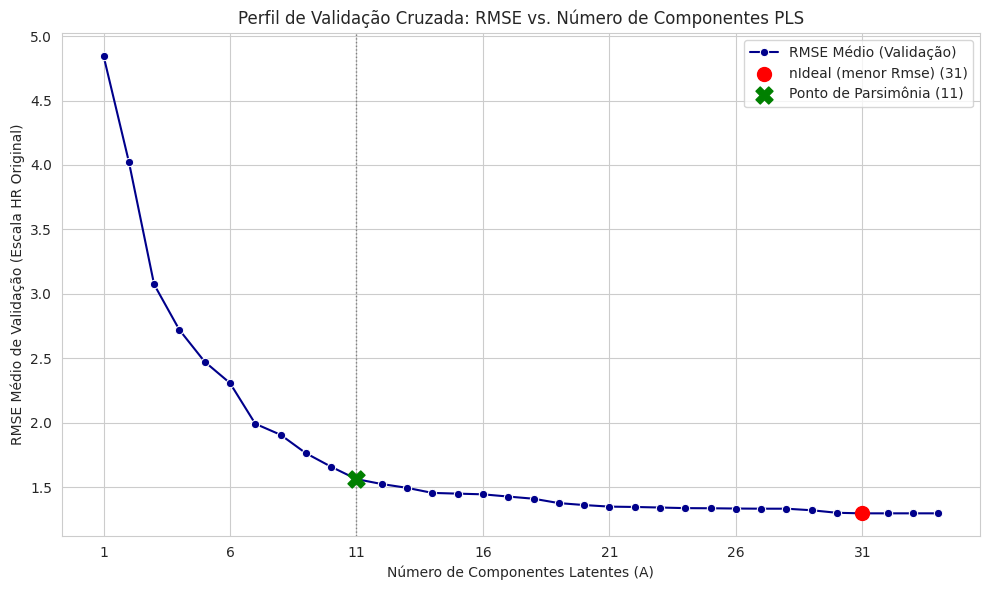

In [12]:
sns.set_style("whitegrid")

# 1. Para facilitar o trabalho, vamos transformar o dict 'resultadosCV' em DataFrame
dfCv = pd.DataFrame.from_dict(resultadosCV, orient='index')
dfCv = dfCv.reset_index().rename(columns={'index': 'Componentes'})


# 2. Plotagem do RMSE Médio (Critério de Escolha)
plt.figure(figsize=(10, 6))

# Linha principal que mostra o RMSE
sns.lineplot(x='Componentes', y='rmseMean', data=dfCv,
             marker='o', color='darkblue', label='RMSE Médio (Validação)')

# O ponto nIdeal encontrado (31, neste caso)
nIdeal = 31
rmse_ideal = dfCv.loc[dfCv['Componentes'] == nIdeal, 'rmseMean'].iloc[0]

plt.scatter(nIdeal, rmse_ideal, color='red', s=100, zorder=5,
            label=f'nIdeal (menor Rmse) ({nIdeal})')


# 3. Adicionando o Ponto de Parsimônia
# Vamos simular um ponto de parsimônia em n=11 para comparação!
nPersimonia = 11
if nPersimonia in dfCv['Componentes'].values:
    rmse_parsimonia = dfCv.loc[dfCv['Componentes'] == nPersimonia, 'rmseMean'].iloc[0]

    plt.scatter(nPersimonia, rmse_parsimonia, color='green', marker='X', s=150, zorder=5,
                label=f'Ponto de Parsimônia ({nPersimonia})')

    # Linha tracejada para ilustrar a estabilidade após o ponto de parsimônia
    plt.axvline(x=nPersimonia, color='gray', linestyle=':', linewidth=1)



plt.title('Perfil de Validação Cruzada: RMSE vs. Número de Componentes PLS')
plt.xlabel('Número de Componentes Latentes (A)')
plt.ylabel('RMSE Médio de Validação (Escala HR Original)')
plt.xticks(range(1, dfCv['Componentes'].max() + 1, 5)) # Mostra ticks a cada 5 componentes
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Definindo o ponto ótimo!!!!
nIdealEscolhido = 21

# 3. Treinar o modelo FINAL com o número ideal de componentes
modeloPLSFinal = PlsNipalsDoZero(numeroComponentes=nIdealEscolhido)

# Usamos XTrain e YTrain (que estão PADRONIZADOS globalmente)
modeloPLSFinal.treinar(XTrain, YTrain)


# 4. Predizer no XTest (que também está PADRONIZADO globalmente)
YTestPredStd = modeloPLSFinal.predizer(XTest)

# > Predição no TREINO (Necessário para o diagnóstico de Overfitting)
YTrainPredStd = modeloPLSFinal.predizer(XTrain)

/tmp/ipython-input-1331116829.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom_tt = float(t.T @ t)
/tmp/ipython-input-1331116829.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[h, 0] = float(c) # c é o coeficiente de regressão da componente t em F


In [14]:
# 5. Despadronizar as predições de volta para a escala original de HR (Batimentos/min)
YTrainPredOrig = YTrainPredStd * desvioY + mediaY
YTestPredOrig = YTestPredStd * desvioY + mediaY

# 6. Avaliando Métricas

# Calcular métricas (comparando predições originais com valores reais originais)
metricasTreino = modeloPLSFinal.calcularMetricas(YTrainOrig, YTrainPredOrig)
metricasTeste = modeloPLSFinal.calcularMetricas(YTestOrig, YTestPredOrig)

print("\n✅ Avaliação no Conjunto de TREINO (Ajuste)")
print(f"    RMSE: {metricasTreino['rmse']:.4f}")
print(f"    R²:   {metricasTreino['r2']:.4f}")

print("\n✅ Avaliação no Conjunto de TESTE (Generalização)")
print(f"    RMSE: {metricasTeste['rmse']:.4f}")
print(f"    R²:   {metricasTeste['r2']:.4f}")


✅ Avaliação no Conjunto de TREINO (Ajuste)
    RMSE: 1.3481
    R²:   0.9830

✅ Avaliação no Conjunto de TESTE (Generalização)
    RMSE: 1.3382
    R²:   0.9832


# ETAPA 5 | Visualização

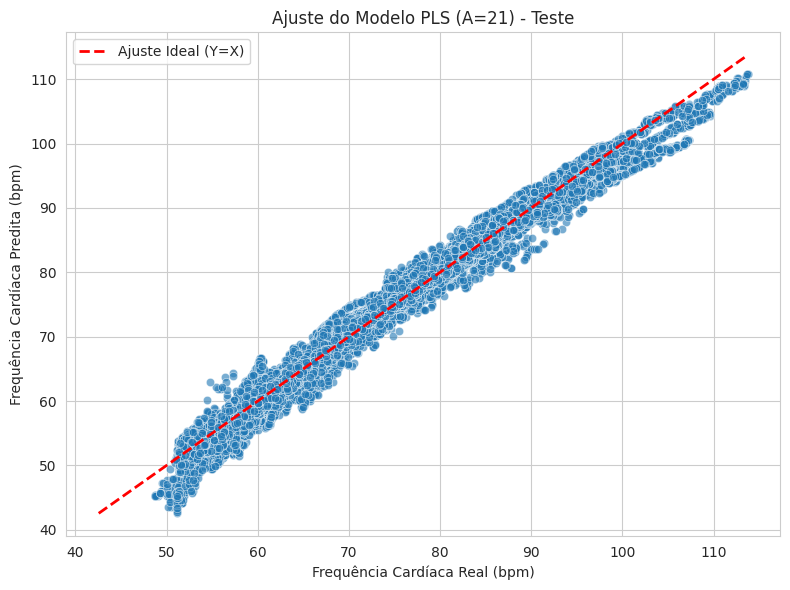


✅ Top 10 Features mais influentes
   Ordenadas pelo valor absoluto do Coeficiente Beta:
          Feature  Coeficiente_Beta
              VLF          1.028334
          MEAN_RR         -0.964784
               HF         -0.873594
          VLF_PCT         -0.761030
      SDRR_REL_RR          0.584320
           HF_PCT          0.337062
            LF_HF         -0.292627
               LF         -0.256277
SDRR_RMSSD_REL_RR         -0.234942
            HF_NU          0.228374


In [15]:
sns.set_style("whitegrid")

# 1. Gráfico de Ajuste (Real vs. Predito) - Conjunto de Teste

# 1.1 Preparação dos dados
YReal = YTestOrig.ravel()
YPred = YTestPredOrig.ravel()
minVal = min(YReal.min(), YPred.min())
maxVal = max(YReal.max(), YPred.max())

plt.figure(figsize=(8, 6))

# Scatter plot: o quão próximos os pontos estão da linha ideal (Y=X)
sns.scatterplot(x=YReal, y=YPred, alpha=0.6)

# Linha de 45 graus (Y=X): Representa o ajuste perfeito
plt.plot([minVal, maxVal], [minVal, maxVal],
         color='red', linestyle='--', linewidth=2,
         label='Ajuste Ideal (Y=X)')

plt.title(f'Ajuste do Modelo PLS (A={nIdealEscolhido}) - Teste')
plt.xlabel('Frequência Cardíaca Real (bpm)')
plt.ylabel('Frequência Cardíaca Predita (bpm)')
plt.legend()
plt.tight_layout()
plt.show()


# 2. Análise dos Coeficientes Beta (ou seja, a importância das variáveis)
# 2.1 Extrair Coeficientes e Nomes
# O vetor beta tem a forma (P x 1)
coefsBeta = modeloPLSFinal.beta.ravel()
nomeFeatures = XTrain.columns.tolist()

# 2.2 Criar DataFrame para Análise
dfCoef = pd.DataFrame({
    'Feature': nomeFeatures,
    'Coeficiente_Beta': coefsBeta
})

# 2.3 Calcular o valor absoluto para ordenar por importância
dfCoef['Abs_Beta'] = np.abs(dfCoef['Coeficiente_Beta'])

# 2.4 Selecionar e imprimir as Top 10 Features mais influentes
dfTop10 = dfCoef.sort_values(by='Abs_Beta', ascending=False).head(10)

print("\n✅ Top 10 Features mais influentes\n   Ordenadas pelo valor absoluto do Coeficiente Beta:")
print(   dfTop10[['Feature', 'Coeficiente_Beta']].to_string(index=False))
